# imports

In [1]:
import sys
sys.path.append("C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/MWLrepo/MiWayLife2/Data_Analysis_Package")
from data_preparation import DataPreparation, Analysis, multi_data_ops
import data_operations as do

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

import data_transforations as data_tr

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


In [2]:
path="C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/Data2/"

## Models

In [3]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, KFold
from scipy.stats import loguniform

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight

from imblearn.ensemble import BalancedRandomForestClassifier



## Scoring

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

### Recall

In [5]:
#cross_val_score(clf, X, y, cv=5, scoring='recall')

#cv= the number of folds in cross validation

### Precision

In [6]:
#cross_val_score(clf, X, y, cv=5, scoring='precision')

### F-beta 

F1 score but you can choose the weighting between recall and precision, where f1 is 50:50

In [7]:
#fbeta_scorer = make_scorer(fbeta_score, beta=2) 
#in model fitting: scoring=fbeta_scorer
##cross_val_score(clf, X, y, cv=5, scoring=fbeta_scorer)
# beta is the ratio of recall:precision, so beta=2 means rcall2:1precision and beta =0.5 means recall1:2precision

### Functions

In [8]:
def lead_prov_grouping(prov):
    if prov in ['Recycled Freemium', 'SPL-Freemium', 'Sold Freemium','Quoted Freemium', 'ABBY Freemium', 'Freemium','CellC-Freemium']:
        return 'Freemium'
    elif prov in ['LeadWarming', 'LeadWarming TN ', 'Lead Warming']:
        return 'LeadWarming'
    elif prov in ['BLDS 101', 'BLDS']:
        return 'BLDS'
    elif prov in ['SD Phone Leads','MWL Phone Leads', 'iTalk External Call Center']:
        return 'Phone leads'
    elif prov in ['Sanlam Direct Cape Referral', 'SDC-Referral', 'MWL Referrals']:
        return 'Refferals'
    elif prov in ['Website',  'Bing', 'SD Web','MWL Web', 'Sanlam Digital','GoogleDisplay','GoogleSearch']:
        return 'Web'
    elif prov in ['MiWayLife', 'Sure_Strat_MWL','Existing Client','Reach_Republic_MWL', 'Newsletter']:
        return 'MWL'
    elif prov in ['Lead-D365-Production', 'Sanlam-Lead-D365-Production']:
        return 'D365'
    elif prov in ['Recycled','Facebook', 'Reinstatement', 'Vicidial','Wills', 'Affiliate', 'Sanlam Direct Cape', 'LiveLeads','SEO',
       'Competitions', 'SDC HIV','Olico']:
        return 'Other'
    else:
        return 'Other'


In [9]:
def data_prep(data,target,features=[],filter=None,column_excl = ['1month_lapse', '3month_lapse', '6month_lapse', 'ann_lapse', 'lapse_flag', 'policy_name','lead_provider_name','campaign_name','occupation']):

    if filter is not None:
        data = data[data[filter].notnull()].copy()
    # impute missing values
    # impute missing values
    df=DataPreparation(df=data)
    imp_dict={'optionality': 'mode',
              'occupation':'none'}
    df.imputating_nulls(imp_dict=imp_dict)
    data=df.imputed_df.copy()
    #grouping lead-provider_name
    data['lead_provider_groups']= data['lead_provider_name'].apply(lead_prov_grouping)
    data=pd.get_dummies(data,columns=['education', 'gender', 'smoker_status',
       'sold_socio_economic_class', 'occupation_class',
       'lead_provider_groups', 'lead_type', 'sales_channel','hiv_group', 'securitygroup_id', 'age_band',
       'income_band', 'last_benefit_amount_band', 'cover_amount_full_band',
       'total_funeral_premium_band', 'original_premium_band','underwriting_outcome'], dtype=int)
    if features == []:
        cols=set(data.columns)
        features=list(cols.difference(column_excl))
         
    X = data[features].copy()
    Y = data[target].astype(int).copy()
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

    return X_train, X_test, y_train, y_test


# Modelling

In [10]:
from sklearn.metrics import make_scorer
def my_custom_accuracy(y_true, y_pred):
    w=2
    cm = confusion_matrix(y_true, y_pred)
    true_0 =(cm[0][0]/(cm[0][0]+cm[0][1]))
    true_1= w*(cm[1][1]/(cm[1][1]+cm[1][0]))

    return (true_0+true_1)/(1+w)
custom_scorer = make_scorer(my_custom_accuracy, greater_is_better=True)

Target = ['1month_lapse', '3month_lapse', '6month_lapse', 'ann_lapse', 'lapse_flag']

In [11]:
def RandomForest(X_train, Y_train,x_test,y_test,class_w_list):

    param_dist = {'n_estimators': randint(50,500),
                  'min_samples_leaf': randint(700,4000),
                  'class_weight': class_w_list}

    # Create a random forest classifier
    rf = RandomForestClassifier()

    # Use random search to find the best hyperparameters
    fbeta_scorer = make_scorer(fbeta_score, beta=2)
    rand_search = RandomizedSearchCV(rf, 
                                     param_distributions = param_dist, 
                                     n_iter=10, 
                                     cv=5,
                                     scoring=custom_scorer, random_state=42) #'recall',fbeta_scorer

    # Fit the random search object to the data
    rand_search.fit(X_train, Y_train)
    print(f'best score {rand_search.best_score_}\n best eatimator {rand_search.best_estimator_}\n best params {rand_search.best_params_}\n ')

    n_estimators=rand_search.best_params_['n_estimators']
    min_samples_leaf=rand_search.best_params_['min_samples_leaf']
    class_weight=rand_search.best_params_['class_weight']

    rfc = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, random_state=42,class_weight=class_weight)
    recall = cross_val_score(rfc,X_train, Y_train, cv=5, scoring='recall')
    precision = cross_val_score(rfc,X_train, Y_train, cv=5, scoring='precision')
    fbeta_scorer = make_scorer(fbeta_score, beta=1.5) 
    fb = cross_val_score(rfc,X_train, Y_train, cv=5, scoring=fbeta_scorer)

    print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}')

    rfc.fit(X_train.copy(),Y_train.copy())
    y_pred = rfc.predict(x_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()
    return conf_matrix

In [12]:
def balanced_rf(X_train, Y_train,x_test,y_test,class_w_list):
    param_dist = {'n_estimators': randint(50,500),
                  'min_samples_leaf': randint(600,4000),
                  'class_weight': class_w_list,
                  'sampling_strategy': ['majority']}

    # Create a balanced random forest classifier
    brf = BalancedRandomForestClassifier(random_state=42)

    # Use random search to find the best hyperparameters
    fbeta_scorer = make_scorer(fbeta_score, beta=2)
    rand_search = RandomizedSearchCV(brf, 
                                     param_distributions = param_dist, 
                                     n_iter=10, 
                                     cv=5,
                                     scoring=fbeta_scorer, random_state=42) #'recall',fbeta_scorer

    # Fit the random search object to the data
    rand_search.fit(X_train, Y_train)
    print(f'best score {rand_search.best_score_}\n best eatimator {rand_search.best_estimator_}\n best params {rand_search.best_params_}\n ')

    n_estimators=rand_search.best_params_['n_estimators']
    min_samples_leaf=rand_search.best_params_['min_samples_leaf']
    class_weight=rand_search.best_params_['class_weight']

    brfc = BalancedRandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, random_state=42,class_weight=class_weight,sampling_strategy='majority')
    recall = cross_val_score(brfc,X_train, Y_train, cv=5, scoring='recall')
    precision = cross_val_score(brfc,X_train, Y_train, cv=5, scoring='precision')
    fbeta_scorer = make_scorer(fbeta_score, beta=1.5) 
    fb = cross_val_score(brfc,X_train, Y_train, cv=5, scoring=fbeta_scorer)

    print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}')

    brfc.fit(X_train.copy(),Y_train.copy())
    y_pred = brfc.predict(x_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()
    

In [13]:
def XGBoost(X_train, Y_train,x_test,y_test,scale_pos_weight):
    print(scale_pos_weight)
    if scale_pos_weight is None:
        param_dist = {'n_estimators': randint(50,300),
                      'min_samples_leaf': randint(1000,2000),
                      'learning_rate': randint(0,3),
                      'max_depth': randint(3,5)}

        # Create a XG-Boost classifier
        xgb = GradientBoostingClassifier()

        # Use random search to find the best hyperparameters
        b=2
        fbeta_scorer = make_scorer(fbeta_score, beta=b)
        rand_search = RandomizedSearchCV(xgb, 
                                         param_distributions = param_dist, 
                                         n_iter=10, 
                                         cv=5,
                                         scoring=custom_scorer,random_state=42)

        # Fit the random search object to the data
        rand_search.fit(X_train, Y_train)
        print(rand_search.best_params_ )
        print(rand_search.best_score_)

        n_estimators=rand_search.best_params_['n_estimators']
        learning_rate = rand_search.best_params_['learning_rate']
        max_depth = rand_search.best_params_['max_depth']
        min_samples_leaf=rand_search.best_params_['min_samples_leaf']

        xgbc = GradientBoostingClassifier(n_estimators = n_estimators,learning_rate=learning_rate,max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)

        recall = cross_val_score(xgbc, X_train, Y_train, cv=5, scoring='recall')
        precision = cross_val_score(xgbc,X_train, Y_train, cv=5, scoring='precision')
        fbeta_scorer = make_scorer(fbeta_score, beta=b) 
        fb = cross_val_score(xgbc,X_train, Y_train, cv=5, scoring=fbeta_scorer)

        print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}')

        xgbc.fit(X_train.copy(),Y_train.copy())
        y_pred = xgbc.predict(x_test)
        conf_matrix = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()
    else:
        param_dist = {'n_estimators': randint(50,300),
                      'min_samples_leaf': randint(1000,2000),
                      'learning_rate': randint(0,3),
                      'max_depth': randint(3,5),
                      'scale_pos_weight':[scale_pos_weight]}

        # Create a XG-Boost classifier
        xgb = GradientBoostingClassifier()

        # Use random search to find the best hyperparameters
        b=2
        fbeta_scorer = make_scorer(fbeta_score, beta=b)
        rand_search = RandomizedSearchCV(xgb, 
                                         param_distributions = param_dist, 
                                         n_iter=10, 
                                         cv=5,
                                         scoring=fbeta_scorer,random_state=42)

        # Fit the random search object to the data
        rand_search.fit(X_train, Y_train)
        print(rand_search.best_params_ )
        print(rand_search.best_score_)

        n_estimators=rand_search.best_params_['n_estimators']
        learning_rate = rand_search.best_params_['learning_rate']
        max_depth = rand_search.best_params_['max_depth']
        min_samples_leaf=rand_search.best_params_['min_samples_leaf']

        xgbc = GradientBoostingClassifier(n_estimators = n_estimators,learning_rate=learning_rate,max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42,scale_pos_weight=scale_pos_weight)

        recall = cross_val_score(xgbc, X_train, Y_train, cv=5, scoring='recall')
        precision = cross_val_score(xgbc,X_train, Y_train, cv=5, scoring='precision')
        fbeta_scorer = make_scorer(fbeta_score, beta=b) 
        fb = cross_val_score(xgbc,X_train, Y_train, cv=5, scoring=fbeta_scorer)

        print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}')

        xgbc.fit(X_train.copy(),Y_train.copy())
        y_pred = xgbc.predict(x_test)
        conf_matrix = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()        

In [14]:
def NeuralNet(X_train, Y_train,x_test,y_test,sw):
    if sw=='y':
        print(sw)
        b=2 #ratio of recall to precision
        sample_weights = compute_sample_weight(class_weight='balanced', y=Y_train)
        #getting best params
        param_dist = {'solver': ['adam'],
                      'alpha': loguniform(1e-5, 1e-3),
                      'hidden_layer_sizes': [(15,),(20,), (25,)],'max_iter':[1000], 
                      'sample_weight':[sample_weights]}


        mlp = MLPClassifier()

        # Use random search to find the best hyperparameters
        fbeta_scorer = make_scorer(fbeta_score, beta=b)
        rand_search = RandomizedSearchCV(mlp, 
                                         param_distributions = param_dist, 
                                         n_iter=3, 
                                         cv=5,
                                         scoring=custom_scorer, random_state=42)

        # Fit the random search object to the data
        rand_search.fit(X_train, Y_train)
        print(f'best score {rand_search.best_score_}\n best eatimator {rand_search.best_estimator_}\n best params {rand_search.best_params_}\n ')

        solver=rand_search.best_params_['solver']
        alpha=rand_search.best_params_['alpha']
        hidden_layer_sizes=rand_search.best_params_['hidden_layer_sizes']

        mlpc = MLPClassifier(solver=solver, alpha=alpha,max_iter=1000,
                            hidden_layer_sizes=hidden_layer_sizes, random_state=42, sample_weight=sample_weights)
        recall = cross_val_score(mlpc, X_train, Y_train, cv=5, scoring='recall')
        precision = cross_val_score(mlpc,X_train, Y_train, cv=5, scoring='precision')
        fbeta_scorer = make_scorer(fbeta_score, beta=b) 
        fb = cross_val_score(mlpc,X_train, Y_train, cv=5, scoring=fbeta_scorer)

        print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}')

        mlpc.fit(X_train.copy(),Y_train.copy())
        y_pred = mlpc.predict(x_test)
        conf_matrix = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()
    else:
        b=2 #ratio of recall to precision
       
        #getting best params
        param_dist = {'solver': ['adam'],
                      'alpha': loguniform(1e-5, 1e-3),
                      'hidden_layer_sizes': [(15,),(20,), (25,)],'max_iter':[1000]}


        mlp = MLPClassifier()

        # Use random search to find the best hyperparameters
        fbeta_scorer = make_scorer(fbeta_score, beta=b)
        rand_search = RandomizedSearchCV(mlp, 
                                         param_distributions = param_dist, 
                                         n_iter=3, 
                                         cv=5,
                                         scoring=custom_scorer, random_state=42)

        # Fit the random search object to the data
        rand_search.fit(X_train, Y_train)
        print(f'best score {rand_search.best_score_}\n best eatimator {rand_search.best_estimator_}\n best params {rand_search.best_params_}\n ')

        solver=rand_search.best_params_['solver']
        alpha=rand_search.best_params_['alpha']
        hidden_layer_sizes=rand_search.best_params_['hidden_layer_sizes']

        mlpc = MLPClassifier(solver=solver, alpha=alpha,max_iter=1000,
                            hidden_layer_sizes=hidden_layer_sizes, random_state=42)
        recall = cross_val_score(mlpc, X_train, Y_train, cv=5, scoring='recall')
        precision = cross_val_score(mlpc,X_train, Y_train, cv=5, scoring='precision')
        fbeta_scorer = make_scorer(fbeta_score, beta=b) 
        fb = cross_val_score(mlpc,X_train, Y_train, cv=5, scoring=fbeta_scorer)

        print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}')

        mlpc.fit(X_train.copy(),Y_train.copy())
        y_pred = mlpc.predict(x_test)
        conf_matrix = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()        

# Comparisons

## Data

In [15]:
imp_features=[]
target= 'ann_lapse'
filter='ann_lapse'
data=pd.DataFrame(pd.read_csv(path+"inception_data_eco_v3.csv"))
data=data.drop(columns=['Unnamed: 0'])
print(data[target].sum()*100/data[target].count())

8.773518462621993


In [71]:
data.shape

(22336, 44)

In [72]:
print(data[target].sum(),data[target].count())

872.0 9939


In [16]:
#scaling numerical data
scale = StandardScaler()
data_s=data.copy()
data_s[[ 'eml','pml', 'benefits_count', 'funeral_count', 'duration_policy_start_delay', '# calls',
       '# calls contacted', 'res_code_QA_sum', 'res_code_claims_sum','res_code_no interest_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_quote_sum', 'res_code_sale_sum','res_code_update_sum', 'inflation', 'unemployment rate']] = scale.fit_transform(data_s[[ 'eml','pml', 'benefits_count', 'funeral_count', 'duration_policy_start_delay', '# calls',
       '# calls contacted', 'res_code_QA_sum', 'res_code_claims_sum','res_code_no interest_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_quote_sum', 'res_code_sale_sum','res_code_update_sum', 'inflation', 'unemployment rate']])
X_train,x_test, Y_train, y_test = data_prep(data_s,target,filter=filter)

In [17]:
print(Y_train.sum()*100/Y_train.count())

8.778769966042008


In [18]:
sm = SMOTE(sampling_strategy=0.6,random_state=42)
X_smote, Y_smote = sm.fit_resample(X_train.copy(), Y_train.copy())
print(Y_smote.sum()*100/Y_smote.count())


37.49569114098587


## Models

### No balancing techniques

In [19]:
class_w_list=[{0:1,1:1}]

best score 0.3333333333333333
 best eatimator RandomForestClassifier(class_weight={0: 1, 1: 1}, min_samples_leaf=3874,
                       n_estimators=485)
 best params {'class_weight': {0: 1, 1: 1}, 'min_samples_leaf': 3874, 'n_estimators': 485}
 


c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

recall score [0. 0. 0. 0. 0.]
 precision score [0. 0. 0. 0. 0.]
 f beta score [0. 0. 0. 0. 0.]
[[1814    0]
 [ 174    0]]


array([[1814,    0],
       [ 174,    0]], dtype=int64)

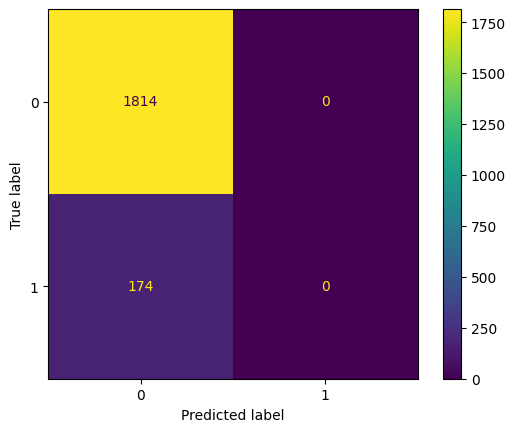

In [20]:
RandomForest(X_train, Y_train,x_test,y_test,class_w_list)

c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Se

best score 0.3248619010880237
 best eatimator BalancedRandomForestClassifier(class_weight={0: 1, 1: 1}, min_samples_leaf=3774,
                               n_estimators=485, random_state=42,
                               sampling_strategy='majority')
 best params {'class_weight': {0: 1, 1: 1}, 'min_samples_leaf': 3774, 'n_estimators': 485, 'sampling_strategy': 'majority'}
 


c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Se

recall score [1. 1. 1. 1. 1.]
 precision score [0.08799497 0.08742138 0.08742138 0.08805031 0.08805031]
 f beta score [0.23871983 0.23741952 0.23741952 0.23884514 0.23884514]


c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


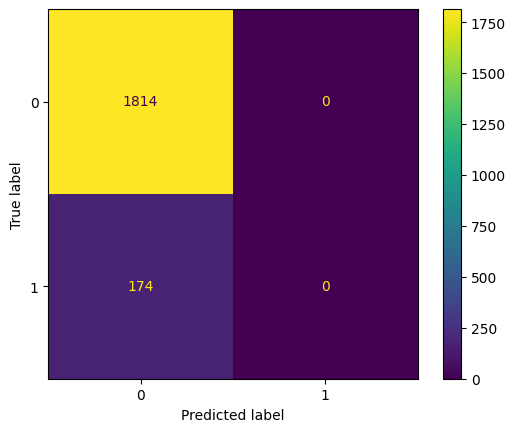

In [21]:
balanced_rf(X_train, Y_train,x_test,y_test,class_w_list)

None
{'learning_rate': 2, 'max_depth': 3, 'min_samples_leaf': 1087, 'n_estimators': 166}
0.43880529867795204
recall score [0.25       0.14388489 0.17266187 0.07857143 0.17142857]
 precision score [0.63636364 0.68965517 0.63157895 0.42307692 0.6       ]
 f beta score [0.28455285 0.17094017 0.2020202  0.09385666 0.2       ]


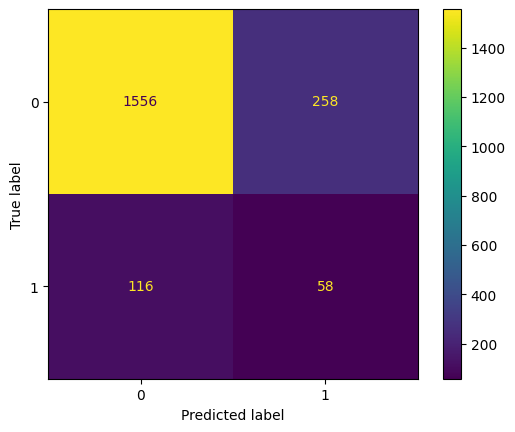

In [22]:
XGBoost(X_train, Y_train,x_test,y_test,scale_pos_weight=None)

best score 0.4701763082036569
 best eatimator MLPClassifier(alpha=0.00015620693675639873, hidden_layer_sizes=(20,),
              max_iter=1000)
 best params {'alpha': 0.00015620693675639873, 'hidden_layer_sizes': (20,), 'max_iter': 1000, 'solver': 'adam'}
 
recall score [0.22857143 0.17985612 0.23741007 0.21428571 0.15714286]
 precision score [0.2962963  0.25773196 0.2244898  0.31914894 0.21359223]
 f beta score [0.23952096 0.1914242  0.23470839 0.2293578  0.16591252]


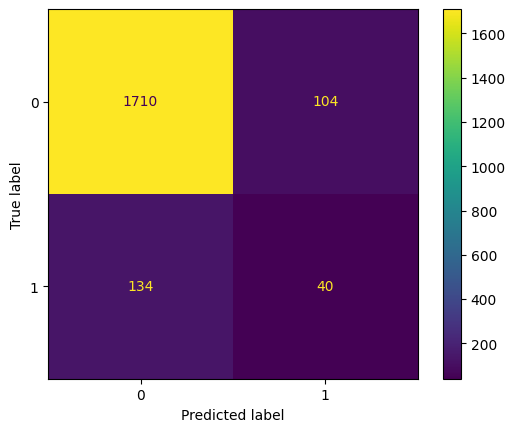

In [23]:
NeuralNet(X_train, Y_train,x_test,y_test,sw='n')

### SMOTE

In [24]:
class_w_list=[{0:1,1:1}]

best score 0.33838869313907916
 best eatimator RandomForestClassifier(class_weight={0: 1, 1: 1}, min_samples_leaf=830,
                       n_estimators=199)
 best params {'class_weight': {0: 1, 1: 1}, 'min_samples_leaf': 830, 'n_estimators': 199}
 
recall score [0.01034483 0.00574713 0.00344828 0.00803674 0.01034483]
 precision score [1. 1. 1. 1. 1.]
 f beta score [0.01487414 0.00828025 0.00497322 0.01156731 0.01487414]
[[1814    0]
 [ 174    0]]


array([[1814,    0],
       [ 174,    0]], dtype=int64)

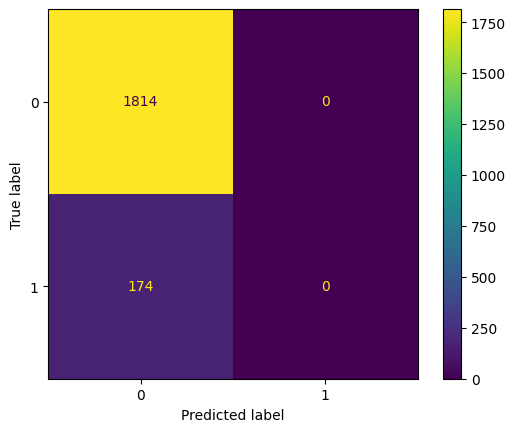

In [25]:
RandomForest(X_smote,Y_smote,x_test,y_test,class_w_list)

c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Se

best score 0.7499654934898657
 best eatimator BalancedRandomForestClassifier(class_weight={0: 1, 1: 1}, min_samples_leaf=2769,
                               n_estimators=264, random_state=42,
                               sampling_strategy='majority')
 best params {'class_weight': {0: 1, 1: 1}, 'min_samples_leaf': 2769, 'n_estimators': 264, 'sampling_strategy': 'majority'}
 


c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Se

recall score [1. 1. 1. 1. 1.]
 precision score [0.37483843 0.37483843 0.37483843 0.37526928 0.375     ]
 f beta score [0.66086245 0.66086245 0.66086245 0.66127431 0.66101695]


c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


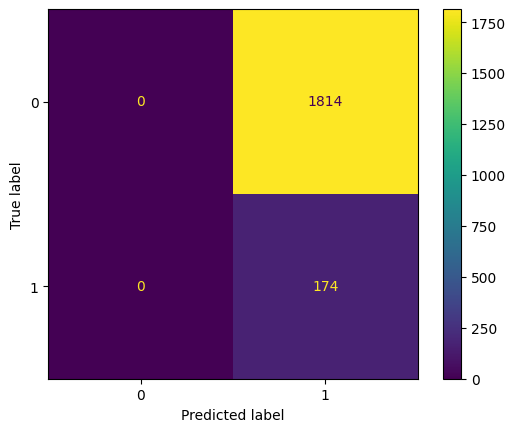

In [26]:
balanced_rf(X_smote,Y_smote,x_test,y_test,class_w_list)

None
{'learning_rate': 1, 'max_depth': 4, 'min_samples_leaf': 1385, 'n_estimators': 241}
0.8811385383486503
recall score [0.21954023 0.9908046  0.97356322 0.98737084 0.98965517]
 precision score [0.9408867  0.96420582 0.96031746 0.94505495 0.9739819 ]
 f beta score [0.25929948 0.98536808 0.97088492 0.97860719 0.98648029]


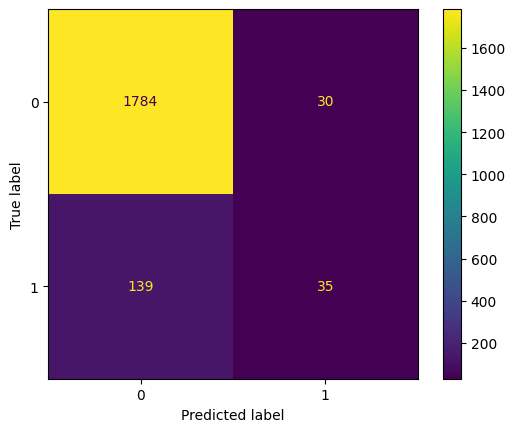

In [27]:
XGBoost(X_smote,Y_smote,x_test,y_test,scale_pos_weight=None)

best score 0.8857494712326813
 best eatimator MLPClassifier(alpha=2.3273922280628698e-05, hidden_layer_sizes=(15,),
              max_iter=1000)
 best params {'alpha': 2.3273922280628698e-05, 'hidden_layer_sizes': (15,), 'max_iter': 1000, 'solver': 'adam'}
 
recall score [0.19770115 1.         0.99885057 1.         1.        ]
 precision score [1.         0.94462541 0.97094972 0.95295405 0.95290252]
 f beta score [0.2354874  0.98841172 0.99314286 0.99022283 0.9902117 ]


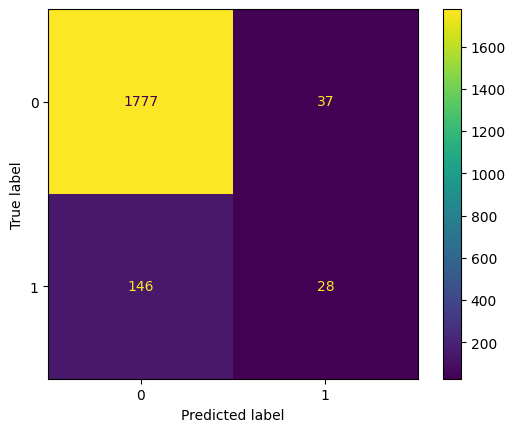

In [28]:
NeuralNet(X_smote,Y_smote,x_test,y_test,sw='n')

### Class weights

In [29]:
class_w_list=[{0:1,1:1.5},{0:1,1:2},{0:1,1:1.8},{0:1,1:1.3}]

best score 0.3333333333333333
 best eatimator RandomForestClassifier(class_weight={0: 1, 1: 1.8}, min_samples_leaf=1560,
                       n_estimators=320)
 best params {'class_weight': {0: 1, 1: 1.8}, 'min_samples_leaf': 1560, 'n_estimators': 320}
 


c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

recall score [0. 0. 0. 0. 0.]
 precision score [0. 0. 0. 0. 0.]
 f beta score [0. 0. 0. 0. 0.]
[[1814    0]
 [ 174    0]]


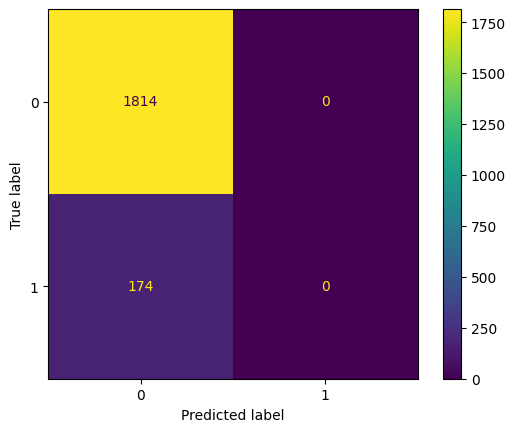

In [30]:
cm=RandomForest(X_train, Y_train,x_test,y_test,class_w_list)

c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Se

best score 0.3248619010880237
 best eatimator BalancedRandomForestClassifier(class_weight={0: 1, 1: 1.8},
                               min_samples_leaf=1460, n_estimators=320,
                               random_state=42, sampling_strategy='majority')
 best params {'class_weight': {0: 1, 1: 1.8}, 'min_samples_leaf': 1460, 'n_estimators': 320, 'sampling_strategy': 'majority'}
 


c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Se

recall score [1. 1. 1. 1. 1.]
 precision score [0.08799497 0.08742138 0.08742138 0.08805031 0.08805031]
 f beta score [0.23871983 0.23741952 0.23741952 0.23884514 0.23884514]


c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


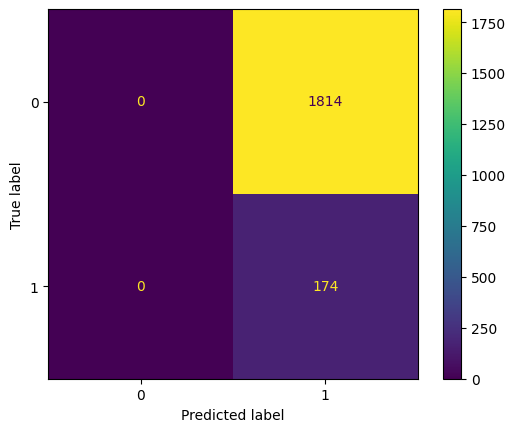

In [31]:
balanced_rf(X_train, Y_train,x_test,y_test,class_w_list)

### SMOTE and class weight

In [32]:
class_w_list=[{0:1,1:1.5},{0:1,1:2},{0:1,1:1.8},{0:1,1:1.3}]

best score 0.7185299730279412
 best eatimator RandomForestClassifier(class_weight={0: 1, 1: 1.8}, min_samples_leaf=1560,
                       n_estimators=320)
 best params {'class_weight': {0: 1, 1: 1.8}, 'min_samples_leaf': 1560, 'n_estimators': 320}
 
recall score [0.74137931 0.91149425 0.93333333 0.92996556 0.92758621]
 precision score [0.44729542 0.4700652  0.48189911 0.46551724 0.46945899]
 f beta score [0.6166348  0.70716148 0.7245024  0.71153456 0.71338229]
[[867 947]
 [ 55 119]]


array([[867, 947],
       [ 55, 119]], dtype=int64)

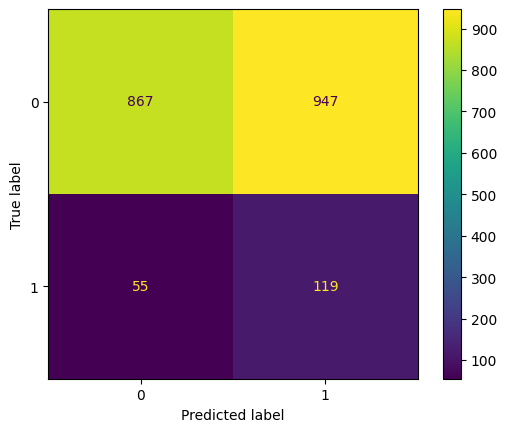

In [33]:
RandomForest(X_smote,Y_smote,x_test,y_test,class_w_list)

c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Se

best score 0.7499654934898657
 best eatimator BalancedRandomForestClassifier(class_weight={0: 1, 1: 1.8},
                               min_samples_leaf=1460, n_estimators=320,
                               random_state=42, sampling_strategy='majority')
 best params {'class_weight': {0: 1, 1: 1.8}, 'min_samples_leaf': 1460, 'n_estimators': 320, 'sampling_strategy': 'majority'}
 


c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Se

recall score [1. 1. 1. 1. 1.]
 precision score [0.37483843 0.37483843 0.37483843 0.37526928 0.375     ]
 f beta score [0.66086245 0.66086245 0.66086245 0.66127431 0.66101695]


c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


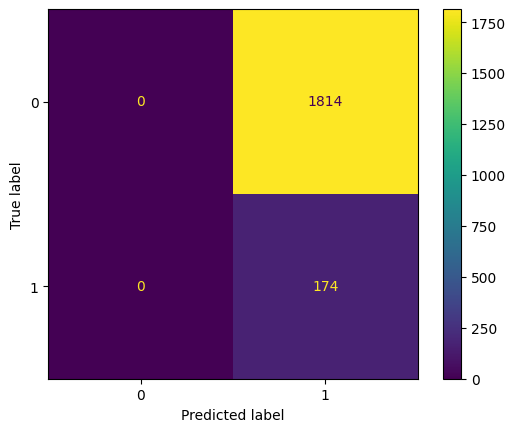

In [34]:
balanced_rf(X_smote,Y_smote,x_test,y_test,class_w_list)